In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

In [2]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
EVENT = "FeedbackOnset"

# output dir that was specified in the decode_features_with_pseudo.py
OUTPUT_DIR = "/data/patrick_res/pseudo"
HYAK_OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"

SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"

PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "FeedbackOnset"
FEATURE_DIMS = ["Color", "Shape", "Pattern"]

In [3]:
def make_decoding_figure(accs, labels, baseline, ax, colors=None):
    for i, acc in enumerate(accs):
        visualization_utils.visualize_accuracy_across_time_bins(
            acc,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            ax,
            label=labels[i],
            right_align=True, 
            color=None if colors is None else colors[i]
        )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(baseline, color='black', linestyle='dotted')


### First column decoding figs

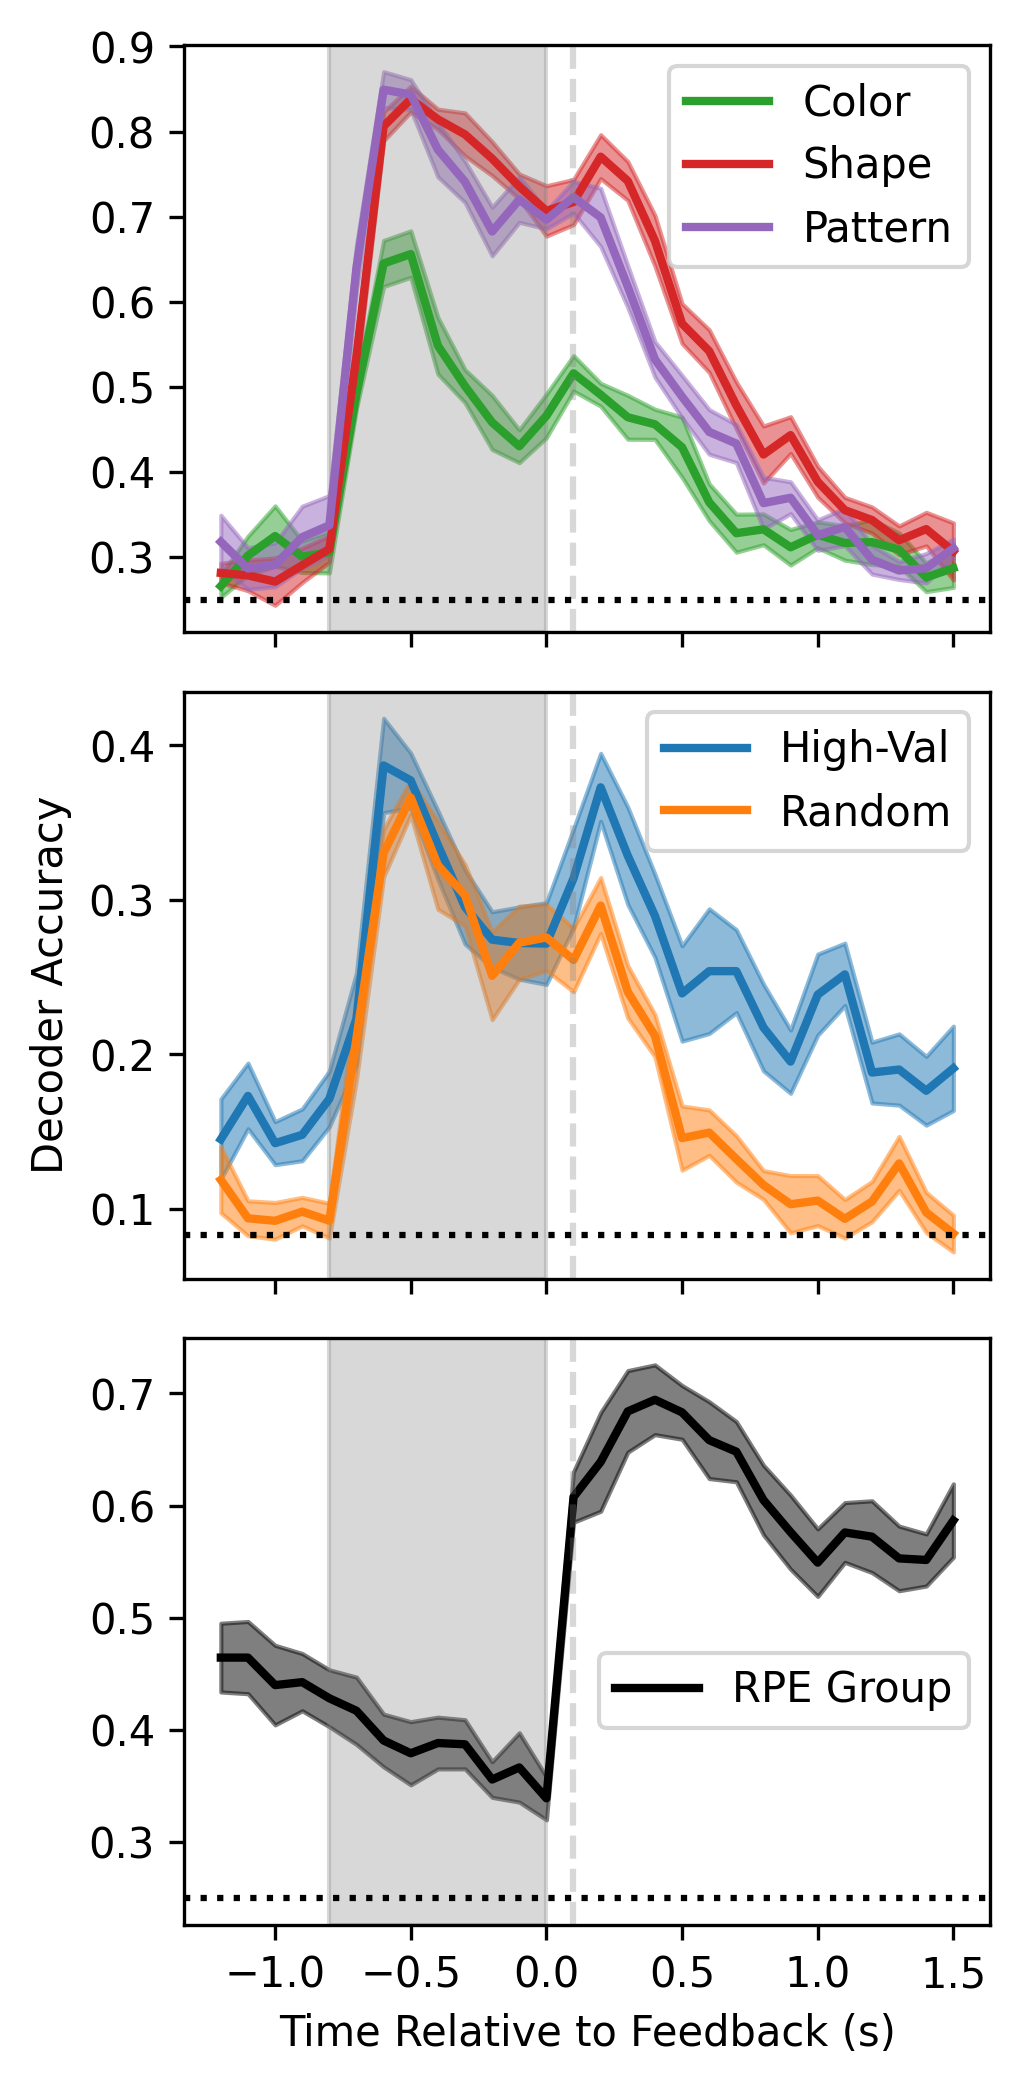

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 7), sharex=True, dpi=300)

feature_accs = []
for feature_dim in FEATURE_DIMS:
    feature_accs.append(np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_test_accs.npy")))
make_decoding_figure(feature_accs, FEATURE_DIMS, 0.25, axs[0], colors=["tab:green", "tab:red", "tab:purple"])

high_val_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, "high_val_MaxFeat_rpe_sess_test_accs.npy"))
random_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, "high_val_RandomMaxFeat_rpe_sess_test_accs.npy"))
make_decoding_figure([high_val_accs, random_accs], ["High-Val", "Random"], 1/12, axs[1], colors=["tab:blue", "tab:orange"])
axs[1].set_ylabel("Decoder Accuracy")


rpe_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups_no_proj_test_accs.npy"))
make_decoding_figure([rpe_accs], ["RPE Group"], 0.25, axs[2], colors=["black"])
axs[2].set_xlabel("Time Relative to Feedback (s)")
axs[2].legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))

fig.tight_layout()

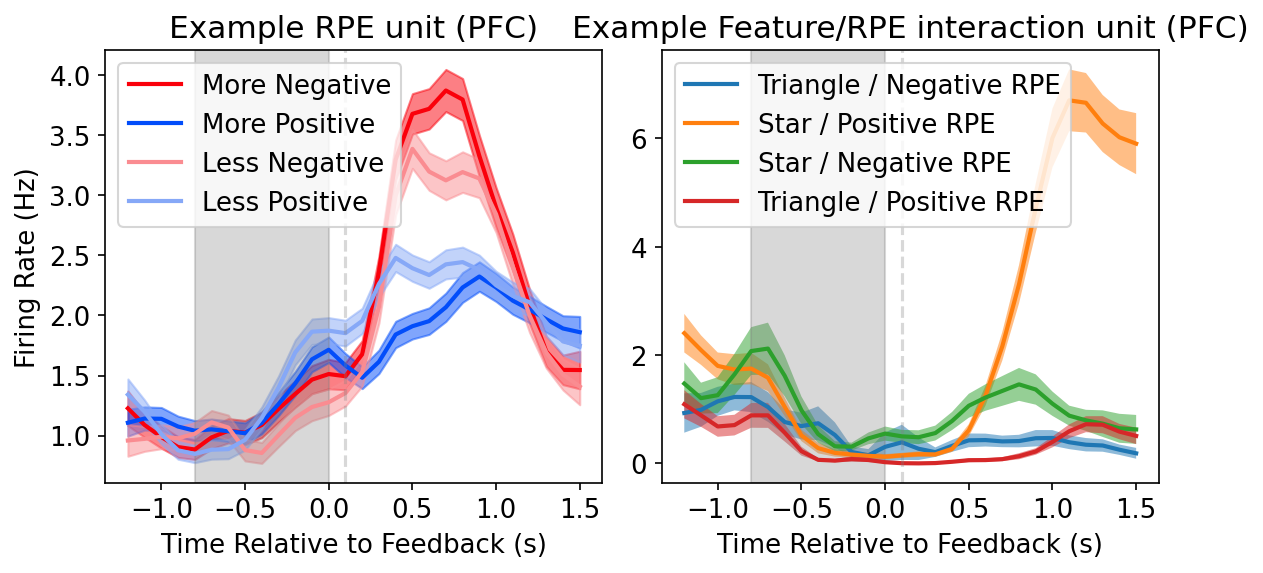

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharex=True)
plt.rcParams.update({'font.size': 12.5})
sess_name = "20180803"
fr_path = f"/data/patrick_res/firing_rates/{sess_name}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
beh = pd.read_csv(behavior_path)
beh = behavioral_utils.get_valid_trials(beh)
beh = behavioral_utils.get_rpe_groups_per_session(sess_name, beh)
beh = beh[~beh.RPEGroup.isna()]
frs = pd.read_pickle(fr_path)
pos = spike_utils.get_unit_positions_per_sess(sess_name)
pos = pos.fillna("unknown")
pos = spike_utils.get_manual_structure(pos)

ax = axs[0]
unit = 17
groups = ["more neg", "less neg", "less pos", "more pos"]
group_colors = {
    "more pos": "#024dfa",
    "less pos": "#86a8f7",
    "less neg": "#fa8c91",
    "more neg": "#fa000b",
}
group_label = {
    "more pos": "More Positive",
    "less pos": "Less Positive",
    "less neg": "Less Negative",
    "more neg": "More Negative",
}
visualization_utils.plot_mean_frs_by_group(sess_name, unit, frs, beh, "RPEGroup", pos, ax, mode="FiringRate", group_colors=group_colors, group_label=group_label)
ax.set_title("Example RPE unit (PFC)")
ax.set_ylabel("Firing Rate (Hz)")

ax = axs[1]


unit = 30

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")
valid_beh_rpes = behavioral_utils.get_rpes_per_session(sess_name, valid_beh)

valid_beh["combined"] = valid_beh["Shape"] + " " + valid_beh["Response"]
# sub_beh = valid_beh[valid_beh.Shape.isin(["STAR", "TRIANGLE"]) & valid_beh.RPEGroup.isin(["more pos", "less pos"])]
sub_beh = valid_beh[valid_beh.Shape.isin(["STAR", "TRIANGLE"])]
group_label = {
    "TRIANGLE Incorrect": "Triangle / Negative RPE",
    "TRIANGLE Correct": "Triangle / Positive RPE",
    "STAR Incorrect": "Star / Negative RPE",
    "STAR Correct": "Star / Positive RPE",
}
visualization_utils.plot_mean_frs_by_group(
    sess_name, unit, frs, sub_beh, "combined", pos, ax, 
    mode="FiringRate", 
    group_colors=None, 
    group_label=group_label)
ax.set_title("Example Feature/RPE interaction unit (PFC)")

fig.tight_layout()



### Cross decoding, projections (2nd column)

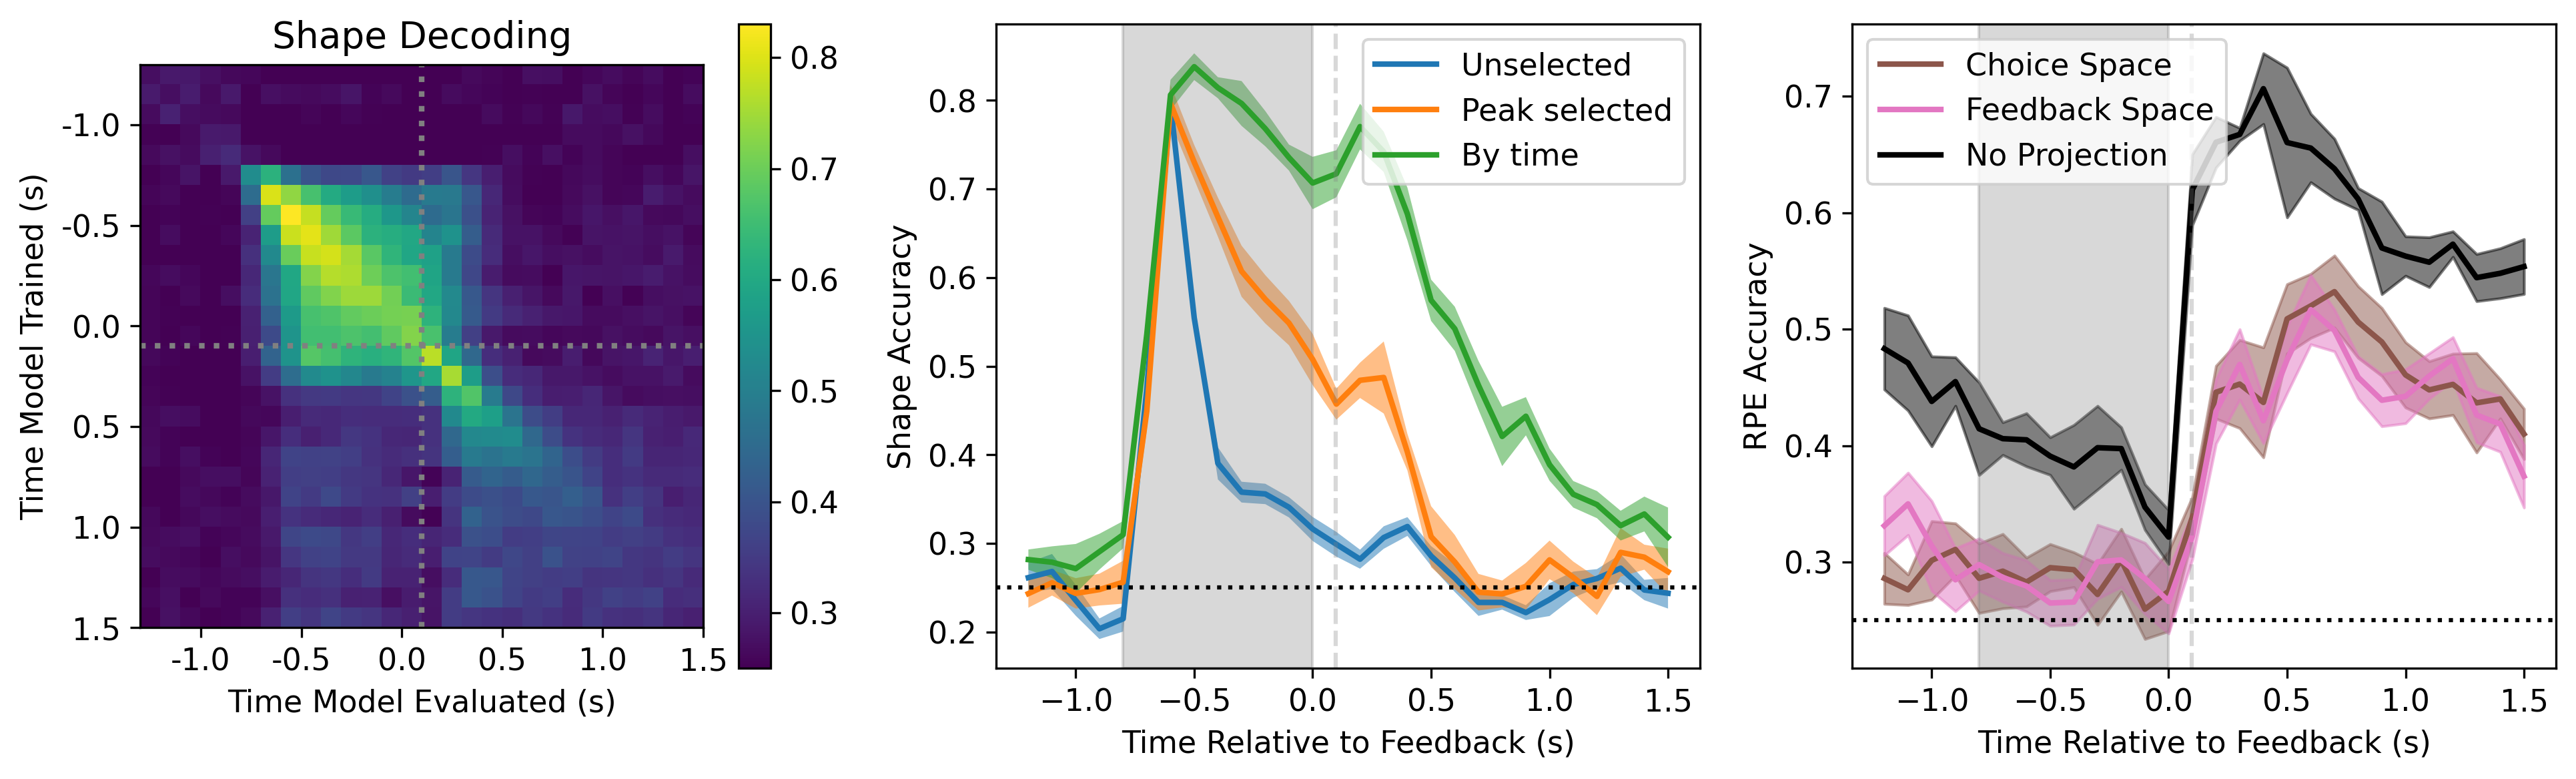

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), dpi=300)
plt.rcParams.update({'font.size': 11})
ax = axs[0]
feature_dim = "Shape"
interval_size = 100
cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_accs.npy"))
colors = ax.matshow(cross_accs)
fig.colorbar(colors, ax=ax)
ratio = 1000 / interval_size
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * ratio - 0.5
colors.set_clim(vmin=0.25)
# tick_labels = np.arange(len(cross_accs))
# tick_pos = np.arange(len(cross_accs))
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
ax.set_xlabel("Time Model Evaluated (s)")
ax.set_ylabel("Time Model Trained (s)")
ax.set_title("Shape Decoding")
# ax.set_title(f"{feature_dim} Decoders Mean Accuracies Across Timebins")
ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=2)
ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=2)

ax = axs[1]
fix_cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_fixation_on_selections_cross_accs_all.npy"))
cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_acc_alls.npy"))
select_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_test_accs.npy"))
visualization_utils.visualize_accuracy_across_time_bins(
    fix_cross_accs[0, :, :],
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Unselected",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    cross_accs[6, :, :],
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Peak selected",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    select_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"By time",
    right_align=True, 
)
ax.legend()
ax.set_ylabel("Shape Accuracy")
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")

ax = axs[2]
fb_proj_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups_orth_many_fb_test_accs.npy"))
choic_proj_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups_orth_many_choice_test_accs.npy"))
base_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups__test_accs.npy"))
visualization_utils.visualize_accuracy_across_time_bins(
    fb_proj_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Choice Space",
    color="tab:brown",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    choic_proj_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Feedback Space",
    color="tab:pink",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    base_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"No Projection",
    color="black",
    right_align=True, 
)
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("RPE Accuracy")
fig.tight_layout()

Text(0, 0.5, 'RPE Accuracy')

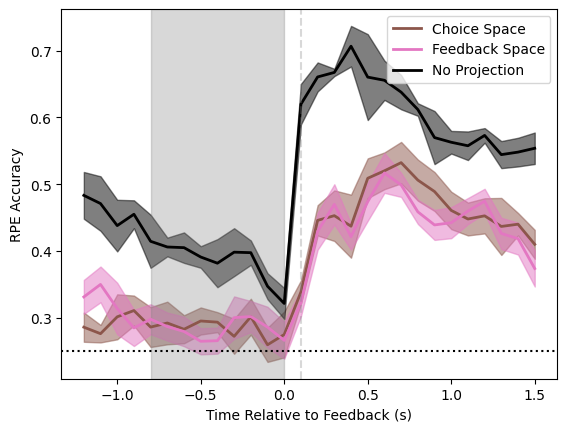

In [4]:
fig, ax = plt.subplots()
fb_proj_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups_orth_many_fb_test_accs.npy"))
choic_proj_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups_orth_many_choice_test_accs.npy"))
base_accs = np.load(os.path.join(HYAK_OUTPUT_DIR, f"rpe_groups__test_accs.npy"))
visualization_utils.visualize_accuracy_across_time_bins(
    fb_proj_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Choice Space",
    color="tab:brown",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    choic_proj_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Feedback Space",
    color="tab:pink",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    base_accs,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"No Projection",
    color="black",
    right_align=True, 
)
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("RPE Accuracy")

### 

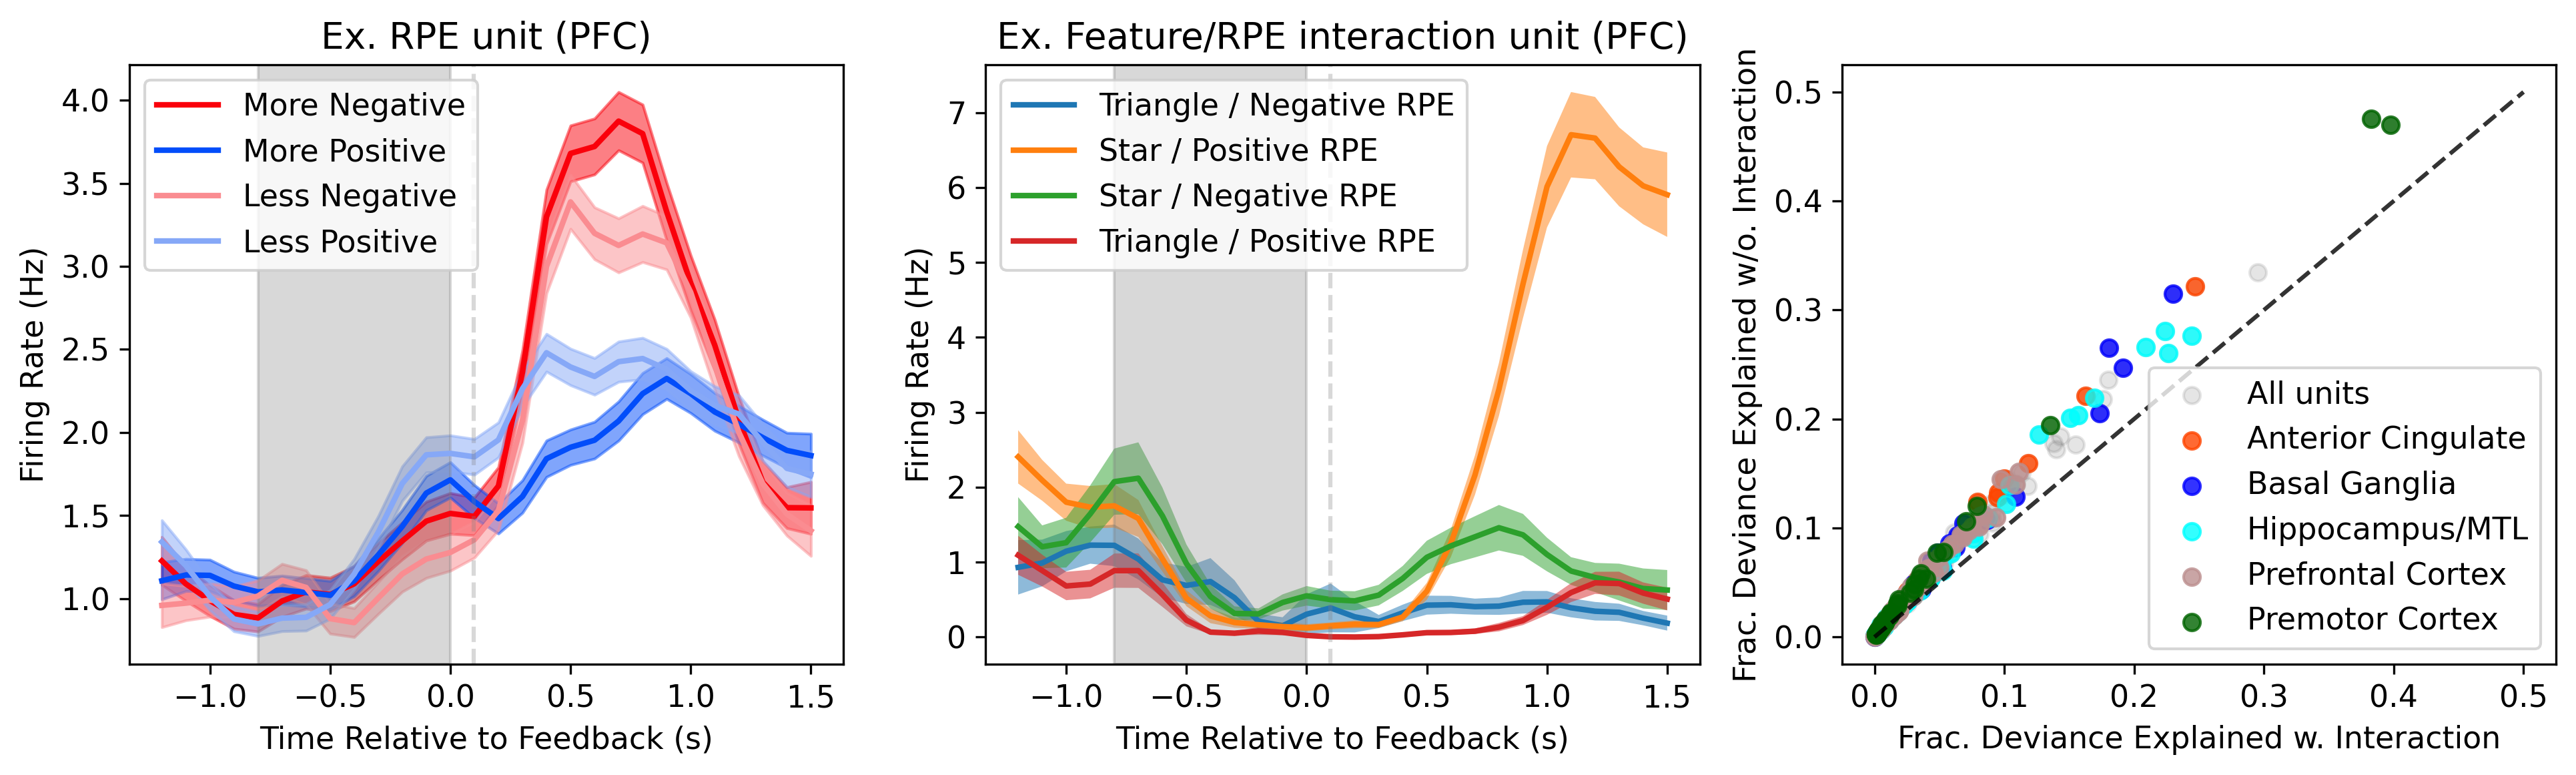

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), dpi=300)
plt.rcParams.update({'font.size': 11})
sess_name = "20180803"
fr_path = f"/data/patrick_res/firing_rates/{sess_name}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
beh = pd.read_csv(behavior_path)
beh = behavioral_utils.get_valid_trials(beh)
beh = behavioral_utils.get_rpe_groups_per_session(sess_name, beh)
beh = beh[~beh.RPEGroup.isna()]
frs = pd.read_pickle(fr_path)
pos = spike_utils.get_unit_positions_per_sess(sess_name)
pos = pos.fillna("unknown")
pos = spike_utils.get_manual_structure(pos)

ax = axs[0]
unit = 17
groups = ["more neg", "less neg", "less pos", "more pos"]
group_colors = {
    "more pos": "#024dfa",
    "less pos": "#86a8f7",
    "less neg": "#fa8c91",
    "more neg": "#fa000b",
}
group_label = {
    "more pos": "More Positive",
    "less pos": "Less Positive",
    "less neg": "Less Negative",
    "more neg": "More Negative",
}
visualization_utils.plot_mean_frs_by_group(sess_name, unit, frs, beh, "RPEGroup", pos, ax, mode="FiringRate", group_colors=group_colors, group_label=group_label)
ax.set_title("Ex. RPE unit (PFC)")
ax.set_ylabel("Firing Rate (Hz)")

ax = axs[1]


unit = 30

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")
valid_beh_rpes = behavioral_utils.get_rpes_per_session(sess_name, valid_beh)

valid_beh["combined"] = valid_beh["Shape"] + " " + valid_beh["Response"]
# sub_beh = valid_beh[valid_beh.Shape.isin(["STAR", "TRIANGLE"]) & valid_beh.RPEGroup.isin(["more pos", "less pos"])]
sub_beh = valid_beh[valid_beh.Shape.isin(["STAR", "TRIANGLE"])]
group_label = {
    "TRIANGLE Incorrect": "Triangle / Negative RPE",
    "TRIANGLE Correct": "Triangle / Positive RPE",
    "STAR Incorrect": "Star / Negative RPE",
    "STAR Correct": "Star / Positive RPE",
}
visualization_utils.plot_mean_frs_by_group(
    sess_name, unit, frs, sub_beh, "combined", pos, ax, 
    mode="FiringRate", 
    group_colors=None, 
    group_label=group_label)
ax.set_title("Ex. Feature/RPE interaction unit (PFC)")
ax.set_ylabel("Firing Rate (Hz)")

time_idxs = np.arange(13, 28)
ax = axs[2]
unit_res = pd.read_pickle("/data/patrick_res/glm_unit_res.pickle")
time_unit_res = unit_res[unit_res.TimeIdxs.isin(time_idxs)]
def get_max(group):
    return group.loc[group.interaction_score.idxmax()]
maxes = time_unit_res.groupby("PseudoUnitID").apply(get_max)

# sig_units = maxes[maxes.interaction_score > maxes.sig_bound]
sig_units = maxes
ax.scatter(sig_units.separate_score, sig_units.interaction_score, alpha=0.2, color="gray", label="All units")
for area in ["Anterior Cingulate Gyrus", "Basal Ganglia", "Hippocampus/MTL", "Prefrontal Cortex", "Premotor Cortex"]:
    area_units = sig_units[sig_units.manual_structure == area]
    label = "Anterior Cingulate" if area == "Anterior Cingulate Gyrus" else area
    ax.scatter(area_units.separate_score, area_units.interaction_score, alpha=0.8, label=label, color=visualization_utils.REGION_TO_COLOR[area])
ax.legend()
ax.set_xlabel("Frac. Deviance Explained w. Interaction")
ax.set_ylabel("Frac. Deviance Explained w/o. Interaction")
ax.plot(np.arange(0, 0.6, 0.1), np.arange(0, 0.6, 0.1), linestyle="--", color="black", alpha=0.8)

fig.tight_layout()


 

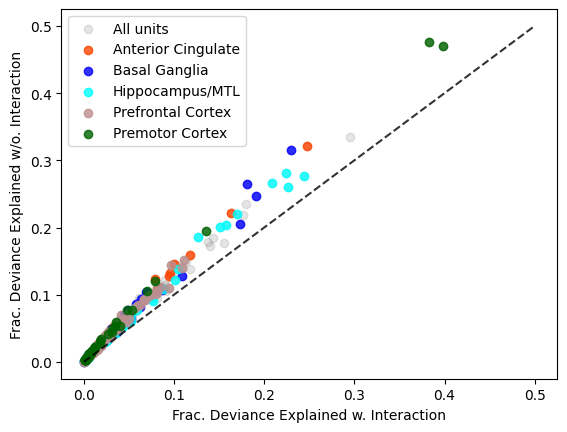

In [6]:
fig, ax = plt.subplots()
time_idxs = np.arange(13, 28)
# ax = axs[2]
unit_res = pd.read_pickle("/data/patrick_res/glm_unit_res.pickle")
time_unit_res = unit_res[unit_res.TimeIdxs.isin(time_idxs)]
def get_max(group):
    return group.loc[group.interaction_score.idxmax()]
maxes = time_unit_res.groupby("PseudoUnitID").apply(get_max)

# sig_units = maxes[maxes.interaction_score > maxes.sig_bound]
sig_units = maxes
ax.scatter(sig_units.separate_score, sig_units.interaction_score, alpha=0.2, color="gray", label="All units")
for area in ["Anterior Cingulate Gyrus", "Basal Ganglia", "Hippocampus/MTL", "Prefrontal Cortex", "Premotor Cortex"]:
    area_units = sig_units[sig_units.manual_structure == area]
    label = "Anterior Cingulate" if area == "Anterior Cingulate Gyrus" else area
    ax.scatter(area_units.separate_score, area_units.interaction_score, alpha=0.8, label=label, color=visualization_utils.REGION_TO_COLOR[area])
ax.legend()
ax.set_xlabel("Frac. Deviance Explained w. Interaction")
ax.set_ylabel("Frac. Deviance Explained w/o. Interaction")
ax.plot(np.arange(0, 0.6, 0.1), np.arange(0, 0.6, 0.1), linestyle="--", color="black", alpha=0.8)